In [2]:
import numpy as np
import scipy
import sys
import os
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from LSPIN_model import Model
from utils import DataSet

SyntaxError: invalid syntax (LSPIN_model.py, line 78)

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

### Linear synthetic data generation

Group 1: $X$ ~ $N(1,0.5)$,  $Y = -2X_1 + X_2 - 0.5X_3$

Group 2: $X$ ~ $N(-1,0.5)$, $Y = -0.5X_3 + X_4 - 2X_5$



In [6]:
np.random.seed(34)

Xs1 = np.random.normal(loc=1,scale=0.5,size=(300,5))
Ys1 = -2*Xs1[:,0]+1*Xs1[:,1]-0.5*Xs1[:,2]

Xs2 = np.random.normal(loc=-1,scale=0.5,size=(300,5))
Ys2 = -0.5*Xs2[:,2]+1*Xs2[:,3]-2*Xs2[:,4]

In [7]:
X_data = np.concatenate((Xs1,Xs2),axis=0)
Y_data = np.concatenate((Ys1.reshape(-1,1),Ys2.reshape(-1,1)),axis=0)

In [8]:
Y_data = Y_data-Y_data.min()
Y_data=Y_data/Y_data.max()

In [9]:
# The ground truth group label of each sample
case_labels = np.concatenate((np.array([1]*300),np.array([2]*300)))

In [10]:
Y_data = np.concatenate((Y_data,case_labels.reshape(-1,1)),axis=1)

In [11]:
# 10% for validation, 10% for test 
X_train,X_remain,yc_train,yc_remain = train_test_split(X_data,Y_data,train_size=0.8,shuffle=True,random_state=34)
X_valid,X_test,yc_valid,yc_test = train_test_split(X_remain,yc_remain,train_size=0.5,shuffle=True,random_state=34)

In [12]:
# Only 10 samples used for training
X_train,_,yc_train,_ = train_test_split(X_train,yc_train,train_size=10,shuffle=True,random_state=34)

In [13]:
print("Sample sizes:")
print(X_train.shape[0],X_valid.shape[0],X_test.shape[0])

Sample sizes:
10 60 60


In [14]:
y_train = yc_train[:,0].reshape(-1,1)
y_valid = yc_valid[:,0].reshape(-1,1)
y_test = yc_test[:,0].reshape(-1,1)

In [15]:
train_label = yc_train[:,1]
valid_label = yc_valid[:,1]
test_label= yc_test[:,1]

In [16]:
from collections import Counter
Counter(train_label)

Counter({2.0: 6, 1.0: 4})

In [17]:
Counter(valid_label)

Counter({2.0: 29, 1.0: 31})

In [18]:
dataset = DataSet(**{'_data':X_train, '_labels':y_train,
                '_valid_data':X_valid, '_valid_labels':y_valid,
                '_test_data':X_test, '_test_labels':y_test})

In [19]:
# reference ground truth feature matrix (training/test)
ref_feat_mat_train = np.array([[1,1,1,0,0] if label == 1 else [0,0,1,1,1] for label in train_label])
ref_feat_mat_test = np.array([[1,1,1,0,0] if label == 1 else [0,0,1,1,1] for label in test_label])

### LLSPIN

In [22]:
def llspin_objective(trial):  
    global model
            
    params = {
        "feature_selection" : True,
        "sigma" : 0.5,
        "display_step" : 500,
        "hidden_layers_node" : [100,100,10,1], # hidden layers: 100,100,10,1
        "input_node" : X_train.shape[1],
        "output_node" : 1
    }
    params['stddev_input'] = 0.1 
    params['activation']= 'none'
    params['batch_size']= X_train.shape[0]
    params['feature_selection_dimension']=[10]
    params['lam'] = trial.suggest_loguniform('lam',1e-3,1e-2)
    params['learning_rate'] = trial.suggest_loguniform('learning_rate', 1e-2, 2e-1)
    num_epoch = trial.suggest_categorical('num_epoch', [2000,5000,10000,15000])

    model_dir =None
    model = Model(**params)
    train_acces, train_losses, val_acces, val_losses = model.train(trial, dataset, model_dir, num_epoch=num_epoch)

    print("In trial:---------------------")
    val_prediction = model.test(X_valid)[0]
    mse = mean_squared_error(y_valid.reshape(-1),val_prediction.reshape(-1))
    print("validation mse: {}".format(mse))
    
    loss= mse
            
    return loss
        
def callback(study,trial):
    global best_model
    if study.best_trial == trial:
        best_model = model

In [23]:
best_model = None
model = None
study = optuna.create_study(pruner=None)
study.optimize(llspin_objective, n_trials=100, callbacks=[callback])

[I 2021-06-07 18:42:13,455] A new study created in memory with name: no-name-63c2f283-7476-4d4a-8782-4d2798b485e9







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



num_samples : 10
Epoch: 500 train loss=0.017082859 valid loss= 0.012888828
train reg_fs: 0.004163460806012154
Epoch: 1000 train loss=0.017388588 valid loss= 0.012372995
train reg_fs: 0.004205964971333742
Epoch: 1500 train loss=0.010543897 valid loss= 0.012051567
train reg_fs: 0.004225475713610649
Epoch: 2000 train loss=0.015496747 valid loss= 0.011280326
train reg_fs: 0.004233748652040958
Epoch: 2500 train loss=0.010254271 valid loss= 0.011088714
train reg_fs: 0.00422280840575695
Epoch: 3000 train loss=0.007823689 valid loss= 0.010987395
train reg_fs: 0.004192065913230181
Epoch: 3500 train loss=0.008171651 valid loss= 0.010063154
train reg_fs: 0.004159087780863047
Epoch: 4000 train loss=0.009584986 valid loss= 0.009677341
train reg_fs: 0.004125325009226799
Epoch: 4500 train loss=0.007959045 valid loss= 0.008828618
train reg_fs: 0.004094329196959734
Epoch: 5000 train loss=0.010105012 va

[I 2021-06-07 18:43:17,028] Trial 0 finished with value: 0.0020889255863539547 and parameters: {'lam': 0.004927018478614294, 'learning_rate': 0.024424042119870894, 'num_epoch': 10000}. Best is trial 0 with value: 0.0020889255863539547.


Epoch: 10000 train loss=0.006256951 valid loss= 0.005928251
train reg_fs: 0.003749425755813718
Optimization Finished!
test loss: 0.006102028302848339, test acc: 1.0
In trial:---------------------
validation mse: 0.0020889255863539547
num_samples : 10
Epoch: 500 train loss=0.012221505 valid loss= 0.007392874
train reg_fs: 0.001980807865038514
Epoch: 1000 train loss=0.006189080 valid loss= 0.007732480
train reg_fs: 0.0020118753891438246
Epoch: 1500 train loss=0.011017598 valid loss= 0.008393418
train reg_fs: 0.0020200328435748816


[I 2021-06-07 18:43:30,727] Trial 1 finished with value: 0.0047921307633848175 and parameters: {'lam': 0.00224475864833115, 'learning_rate': 0.09061963241154962, 'num_epoch': 2000}. Best is trial 0 with value: 0.0020889255863539547.


Epoch: 2000 train loss=0.004990913 valid loss= 0.006808318
train reg_fs: 0.0020139808766543865
Optimization Finished!
test loss: 0.00713279377669096, test acc: 1.0
In trial:---------------------
validation mse: 0.0047921307633848175
num_samples : 10
Epoch: 500 train loss=0.021683356 valid loss= 0.010146989
train reg_fs: 0.004057804588228464
Epoch: 1000 train loss=0.010695552 valid loss= 0.010790971
train reg_fs: 0.004110498353838921
Epoch: 1500 train loss=0.007166344 valid loss= 0.009813948
train reg_fs: 0.004101005848497152
Epoch: 2000 train loss=0.016711924 valid loss= 0.008073894
train reg_fs: 0.004030206706374884
Epoch: 2500 train loss=0.006949844 valid loss= 0.007687825
train reg_fs: 0.003930754028260708
Epoch: 3000 train loss=0.009484207 valid loss= 0.006797547
train reg_fs: 0.0038275648839771748
Epoch: 3500 train loss=0.013306601 valid loss= 0.005839625
train reg_fs: 0.0037364610470831394
Epoch: 4000 train loss=0.013328041 valid loss= 0.005741736
train reg_fs: 0.0036550813820213

[I 2021-06-07 18:44:02,771] Trial 2 finished with value: 0.0025509456761361946 and parameters: {'lam': 0.004652716190141008, 'learning_rate': 0.0701870991086343, 'num_epoch': 5000}. Best is trial 0 with value: 0.0020889255863539547.


Epoch: 5000 train loss=0.006274582 valid loss= 0.006118827
train reg_fs: 0.0035378416068851948
Optimization Finished!
test loss: 0.006202762946486473, test acc: 1.0
In trial:---------------------
validation mse: 0.0025509456761361946
num_samples : 10
Epoch: 500 train loss=0.017360538 valid loss= 0.013427481
train reg_fs: 0.006695840507745743
Epoch: 1000 train loss=0.011972673 valid loss= 0.013029356
train reg_fs: 0.0067109777592122555
Epoch: 1500 train loss=0.016708918 valid loss= 0.012467748
train reg_fs: 0.006655930541455746
Epoch: 2000 train loss=0.011644462 valid loss= 0.013352912
train reg_fs: 0.006529373116791248
Epoch: 2500 train loss=0.013344629 valid loss= 0.013163691
train reg_fs: 0.0063719297759234905
Epoch: 3000 train loss=0.011959812 valid loss= 0.012281744
train reg_fs: 0.006198951508849859
Epoch: 3500 train loss=0.015301536 valid loss= 0.012393642
train reg_fs: 0.006047871895134449
Epoch: 4000 train loss=0.010478195 valid loss= 0.011508787
train reg_fs: 0.005905229132622

[I 2021-06-07 18:45:35,574] Trial 3 finished with value: 0.003977444598867114 and parameters: {'lam': 0.00787074333928316, 'learning_rate': 0.03487222416277155, 'num_epoch': 15000}. Best is trial 0 with value: 0.0020889255863539547.


Epoch: 15000 train loss=0.007552603 valid loss= 0.008851998
train reg_fs: 0.004722239915281534
Optimization Finished!
test loss: 0.008915446698665619, test acc: 1.0
In trial:---------------------
validation mse: 0.003977444598867114
num_samples : 10
Epoch: 500 train loss=0.012702712 valid loss= 0.007159659
train reg_fs: 0.0008749970002099872
Epoch: 1000 train loss=0.007853322 valid loss= 0.007024700
train reg_fs: 0.0008811700390651822
Epoch: 1500 train loss=0.008154844 valid loss= 0.006567081
train reg_fs: 0.0008785647223703563
Epoch: 2000 train loss=0.009929305 valid loss= 0.006390165
train reg_fs: 0.0008692147093825042
Epoch: 2500 train loss=0.005575351 valid loss= 0.005000520
train reg_fs: 0.0008608990465290844
Epoch: 3000 train loss=0.004637283 valid loss= 0.004262076
train reg_fs: 0.000854589743539691
Epoch: 3500 train loss=0.004626405 valid loss= 0.003505003
train reg_fs: 0.000847900693770498
Epoch: 4000 train loss=0.005135344 valid loss= 0.004000553
train reg_fs: 0.0008407949935

[I 2021-06-07 18:46:38,443] Trial 4 finished with value: 0.0010752054741934962 and parameters: {'lam': 0.001035152259866348, 'learning_rate': 0.03505659685677204, 'num_epoch': 10000}. Best is trial 4 with value: 0.0010752054741934962.


Epoch: 10000 train loss=0.003559629 valid loss= 0.001853115
train reg_fs: 0.0007655687513761222
Optimization Finished!
test loss: 0.0020743526984006166, test acc: 1.0
In trial:---------------------
validation mse: 0.0010752054741934962
num_samples : 10
Epoch: 500 train loss=0.011274687 valid loss= 0.009335619
train reg_fs: 0.0017090120818465948
Epoch: 1000 train loss=0.008889034 valid loss= 0.009166956
train reg_fs: 0.0017356355674564838
Epoch: 1500 train loss=0.008329604 valid loss= 0.008569258
train reg_fs: 0.001739890780299902


[I 2021-06-07 18:46:52,228] Trial 5 finished with value: 0.0064265065892820765 and parameters: {'lam': 0.0019906955579042664, 'learning_rate': 0.047733018954318314, 'num_epoch': 2000}. Best is trial 4 with value: 0.0010752054741934962.


Epoch: 2000 train loss=0.006901350 valid loss= 0.008175173
train reg_fs: 0.0017270990647375584
Optimization Finished!
test loss: 0.008816452696919441, test acc: 1.0
In trial:---------------------
validation mse: 0.0064265065892820765
num_samples : 10
Epoch: 500 train loss=0.011128817 valid loss= 0.008753171
train reg_fs: 0.0026107681915163994
Epoch: 1000 train loss=0.010632508 valid loss= 0.010961786
train reg_fs: 0.0026034293696284294
Epoch: 1500 train loss=0.007381289 valid loss= 0.009002181
train reg_fs: 0.002531600883230567
Epoch: 2000 train loss=0.004815103 valid loss= 0.008629251
train reg_fs: 0.0024992937687784433
Epoch: 2500 train loss=0.005503241 valid loss= 0.007865005
train reg_fs: 0.0024854892399162054
Epoch: 3000 train loss=0.004860429 valid loss= 0.007516863
train reg_fs: 0.0024788533337414265
Epoch: 3500 train loss=0.007145326 valid loss= 0.007178391
train reg_fs: 0.002490200800821185
Epoch: 4000 train loss=0.007114625 valid loss= 0.007444371
train reg_fs: 0.002478444715

[I 2021-06-07 18:47:24,058] Trial 6 finished with value: 0.005047576999216768 and parameters: {'lam': 0.002947669761048189, 'learning_rate': 0.1304964072454408, 'num_epoch': 5000}. Best is trial 4 with value: 0.0010752054741934962.


Epoch: 5000 train loss=0.006152906 valid loss= 0.007526995
train reg_fs: 0.0024476596154272556
Optimization Finished!
test loss: 0.007548806723207235, test acc: 1.0
In trial:---------------------
validation mse: 0.005047576999216768
num_samples : 10
Epoch: 500 train loss=0.012898826 valid loss= 0.009487173
train reg_fs: 0.0021047599148005247
Epoch: 1000 train loss=0.011955120 valid loss= 0.008959239
train reg_fs: 0.002115724142640829
Epoch: 1500 train loss=0.006416965 valid loss= 0.007899761
train reg_fs: 0.0021046216133981943


[I 2021-06-07 18:47:38,033] Trial 7 finished with value: 0.00508217467790855 and parameters: {'lam': 0.0024933118804860138, 'learning_rate': 0.029779834239611475, 'num_epoch': 2000}. Best is trial 4 with value: 0.0010752054741934962.


Epoch: 2000 train loss=0.017211739 valid loss= 0.007186251
train reg_fs: 0.0020783666986972094
Optimization Finished!
test loss: 0.009350382722914219, test acc: 1.0
In trial:---------------------
validation mse: 0.00508217467790855
num_samples : 10
Epoch: 500 train loss=0.015327052 valid loss= 0.006873445
train reg_fs: 0.0010927078546956182
Epoch: 1000 train loss=0.011930894 valid loss= 0.007229929
train reg_fs: 0.0010842438787221909
Epoch: 1500 train loss=0.006108251 valid loss= 0.005730150
train reg_fs: 0.0010549870785325766


[I 2021-06-07 18:47:52,029] Trial 8 finished with value: 0.0033306740384031978 and parameters: {'lam': 0.001231756819901638, 'learning_rate': 0.13088460360096935, 'num_epoch': 2000}. Best is trial 4 with value: 0.0010752054741934962.


Epoch: 2000 train loss=0.003878758 valid loss= 0.004377028
train reg_fs: 0.001032091910019517
Optimization Finished!
test loss: 0.004651795607060194, test acc: 1.0
In trial:---------------------
validation mse: 0.0033306740384031978
num_samples : 10
Epoch: 500 train loss=0.015282326 valid loss= 0.008557163
train reg_fs: 0.0011728341924026608
Epoch: 1000 train loss=0.012480865 valid loss= 0.008015867
train reg_fs: 0.0011835591867566109


KeyboardInterrupt: 

In [46]:
gate_mat_train = best_model.get_prob_alpha(X_train)

In [47]:
best_lr = study.best_params['learning_rate']
best_epoch = study.best_params['num_epoch']
best_lam = study.best_params['lam']

In [48]:
y_pred_llspin = best_model.test(X_test)[0]
            
print("Trial Finished*************")
print("Best model's lambda: {}".format(best_lam))
print("Best model's learning rate: {}".format(best_lr))
print("Best model's num of epochs: {}".format(best_epoch))
print("Test mse : {}".format(mean_squared_error(y_test.reshape(-1),y_pred_llspin.reshape(-1))))
print("Test r2 : {}".format(r2_score(y_test.reshape(-1),y_pred_llspin.reshape(-1),multioutput='raw_values')[0]))

Trial Finished*************
Best model's lambda: 0.0020811013859500485
Best model's learning rate: 0.15266423143883523
Best model's num of epochs: 15000
Test mse : 0.00025906965903572585
Test r2 : 0.9937485729628137


### Comparing the training gates

In [59]:
import matplotlib.pyplot as plt
from matplotlib import cm,colors

cmap = cm.Blues
bounds=[0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

title_size = 30
xtick_size = 20
ytick_size = 20
xlabel_size = 35
ylabel_size = 35
colorbar_tick_size = 20
title_pad = 10

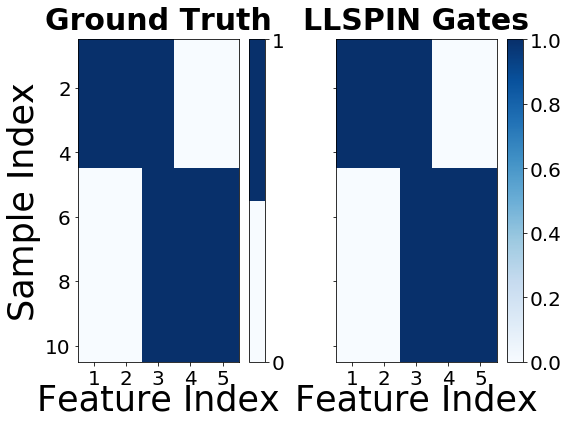

In [69]:
fig, axes = plt.subplots(1, 2,sharex=False, sharey=True,figsize=(8, 6))

sorted_order = np.concatenate((np.where(train_label == 1)[0],np.where(train_label == 2)[0]))

im1 = axes[0].imshow(ref_feat_mat_train[sorted_order,:].astype(int),aspect='auto',cmap=cmap, norm=norm)
axes[0].set_title("Ground Truth",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[0].set_ylabel("Sample Index",fontsize=ylabel_size)
axes[0].set_yticks([1,3,5,7,9])
axes[0].set_yticklabels([2,4,6,8,10],fontsize=ytick_size)
axes[0].set_xticks(list(range(5)))
axes[0].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[0].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)

cbar = fig.colorbar(im1,ax=axes[0], cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)

im2 = axes[1].imshow(gate_mat_train[sorted_order,:],aspect='auto',cmap=cmap)
axes[1].set_title("LLSPIN Gates",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[1].set_yticks([1,3,5,7,9])
axes[1].set_yticklabels([2,4,6,8,10],fontsize=ytick_size)
axes[1].set_xticks(list(range(5)))
axes[1].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[1].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)

cbar = fig.colorbar(im2,ax=axes[1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)

plt.tight_layout()

### Comparing the test gates

In [50]:
gate_mat_test = best_model.get_prob_alpha(X_test)

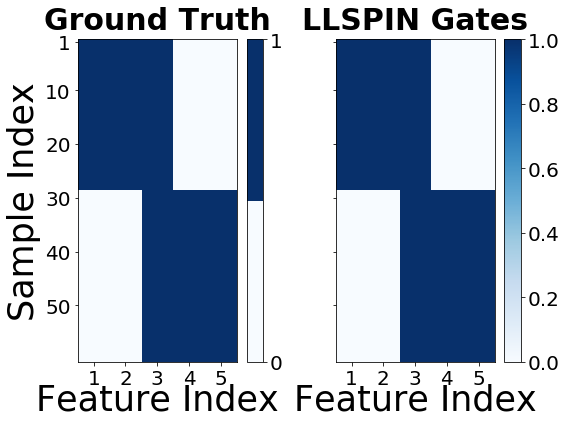

In [70]:
fig, axes = plt.subplots(1, 2,sharex=False, sharey=True,figsize=(8, 6))

fig.subplots_adjust(bottom=0.01)

im1 = axes[0].imshow(ref_feat_mat_test[sorted_order_test,:].astype(int),aspect='auto',cmap=cmap, norm=norm)
axes[0].set_title("Ground Truth",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[0].set_ylabel("Sample Index",fontsize=ylabel_size)
axes[0].set_yticks([0,9,19,29,39,49])
axes[0].set_yticklabels([1,10,20,30,40,50],fontsize=ytick_size)
axes[0].set_xticks(list(range(5)))
axes[0].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[0].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)
cbar = fig.colorbar(im1,ax=axes[0], cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)
    
im2 = axes[1].imshow(gate_mat_test[sorted_order_test,:],aspect='auto',cmap=cmap)
axes[1].set_title("LLSPIN Gates",fontsize=title_size,fontweight="bold",pad=title_pad)
axes[1].set_yticks([0,9,19,29,39,49])
axes[1].set_yticklabels([1,10,20,30,40,50],fontsize=ytick_size)
axes[1].set_xticks(list(range(5)))
axes[1].set_xticklabels(list(range(1,6)),fontsize=xtick_size)
axes[1].set_xlabel("Feature Index",fontsize=xlabel_size,labelpad=-5)
    
cbar = fig.colorbar(im2,ax=axes[1])
cbar.ax.tick_params(labelsize=colorbar_tick_size)

plt.tight_layout()